In [20]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from PIL import Image
import os
import itertools
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
#
from torchvision.utils import make_grid
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os
import torchvision
import itertools
from PIL import Image
import gc
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets, utils

In [2]:
root_dir = "data"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparametre

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 8
LR = 0.0002
EPOCHS = 50
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
DROPOUT = 0.5

## Generator

In [5]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
        ]

        for _ in range(10):
            model += [ResnetBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(DROPOUT),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## Diskriminator

In [6]:
 class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Gradient penalty

In [7]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Data loader

In [9]:
class ImageDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.files_A = sorted(os.listdir(rootA))   # use subset
        self.files_B = sorted(os.listdir(rootB))
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.rootA, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.rootB, self.files_B[index % len(self.files_B)])).convert("RGB")
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageDataset("data/horse2zebra/horse2zebra/trainA", "data/horse2zebra/horse2zebra/trainB", transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

cycle_loss_fn = nn.L1Loss()


In [25]:
## Train

In [11]:
scaler = torch.amp.GradScaler(device='cuda')  # Updated line

scheduler_G = StepLR(optimizer_G, step_size=1, gamma=0.97)      # Halve LR every 10 epochs
scheduler_D_A = StepLR(optimizer_D_A, step_size=1, gamma=0.97)
scheduler_D_B = StepLR(optimizer_D_B, step_size=1, gamma=0.97)

for epoch in range(EPOCHS):  
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # ---------------------
        #  Train Generators
        # ---------------------
        optimizer_G.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            fake_B = G_AB(real_A)
            rec_A = G_BA(fake_B)
            fake_A = G_BA(real_B)
            rec_B = G_AB(fake_A)

            loss_cycle_A = cycle_loss_fn(rec_A, real_A)
            loss_cycle_B = cycle_loss_fn(rec_B, real_B)

            loss_G_AB = -torch.mean(D_B(fake_B))
            loss_G_BA = -torch.mean(D_A(fake_A))

            loss_G = loss_G_AB + loss_G_BA + 10 * (loss_cycle_A + loss_cycle_B)

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ---------------------
        #  Train Discriminator A
        # ---------------------
        optimizer_D_A.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            loss_real = torch.mean(D_A(real_A))
            loss_fake = torch.mean(D_A(fake_A.detach()))
            gp = compute_gradient_penalty(D_A, real_A, fake_A.detach(), device)
            loss_D_A = -loss_real + loss_fake + 10 * gp

        scaler.scale(loss_D_A).backward()
        scaler.step(optimizer_D_A)
        scaler.update()

        # ---------------------
        #  Train Discriminator B
        # ---------------------
        optimizer_D_B.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            loss_real = torch.mean(D_B(real_B))
            loss_fake = torch.mean(D_B(fake_B.detach()))
            gp = compute_gradient_penalty(D_B, real_B, fake_B.detach(), device)
            loss_D_B = -loss_real + loss_fake + 10 * gp

        scaler.scale(loss_D_B).backward()
        scaler.step(optimizer_D_B)
        scaler.update()


        torch.cuda.empty_cache()
        gc.collect()

    print(f"[Epoch {epoch}] [Batch {i}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()

torch.save(G_AB.state_dict(), 'G_AB_model_WG.pth')
torch.save(G_BA.state_dict(), 'G_BA_model_WG.pth')
torch.save(D_A.state_dict(), 'D_A_model_WG.pth')
torch.save(D_B.state_dict(), 'D_B_model_WG.pth')

[Epoch 0] [Batch 266] Loss_G: 5.2836 Loss_D_A: 0.6284 Loss_D_B: 0.0850
[Epoch 1] [Batch 266] Loss_G: 4.8606 Loss_D_A: 0.0268 Loss_D_B: 0.1369
[Epoch 2] [Batch 266] Loss_G: 4.8608 Loss_D_A: 0.0450 Loss_D_B: 0.2222
[Epoch 3] [Batch 266] Loss_G: 5.0206 Loss_D_A: 0.1251 Loss_D_B: -0.0505
[Epoch 4] [Batch 266] Loss_G: 4.5351 Loss_D_A: 0.0179 Loss_D_B: -0.0269
[Epoch 5] [Batch 266] Loss_G: 5.4453 Loss_D_A: 0.0063 Loss_D_B: -0.0026
[Epoch 6] [Batch 266] Loss_G: 4.6295 Loss_D_A: -0.0620 Loss_D_B: -0.0418
[Epoch 7] [Batch 266] Loss_G: 4.0658 Loss_D_A: 0.1091 Loss_D_B: -0.0435
[Epoch 8] [Batch 266] Loss_G: 3.9744 Loss_D_A: 0.2022 Loss_D_B: -0.0079
[Epoch 9] [Batch 266] Loss_G: 4.8876 Loss_D_A: 0.0922 Loss_D_B: 0.0762
[Epoch 10] [Batch 266] Loss_G: 4.5652 Loss_D_A: -0.0730 Loss_D_B: -0.0045
[Epoch 11] [Batch 266] Loss_G: 5.1197 Loss_D_A: -0.0194 Loss_D_B: -0.0069
[Epoch 12] [Batch 266] Loss_G: 4.4820 Loss_D_A: 0.0680 Loss_D_B: -0.0511
[Epoch 13] [Batch 266] Loss_G: 4.6681 Loss_D_A: -0.0643 Loss_D

## Test

In [12]:
def evaluate_cycle_consistency(G_AB, G_BA, dataloader, device, cycle_loss_fn):
    G_AB.eval()
    G_BA.eval()

    total_loss_A = 0.0
    total_loss_B = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)

            # A → B → A
            fake_B = G_AB(real_A)
            recon_A = G_BA(fake_B)
            loss_A = cycle_loss_fn(recon_A, real_A)

            # B → A → B
            fake_A = G_BA(real_B)
            recon_B = G_AB(fake_A)
            loss_B = cycle_loss_fn(recon_B, real_B)

            total_loss_A += loss_A.item()
            total_loss_B += loss_B.item()
            num_samples += real_A.size(0)

    avg_loss_A = total_loss_A / num_samples
    avg_loss_B = total_loss_B / num_samples
    avg_total = (avg_loss_A + avg_loss_B) / 2

    print(f"[Cycle Loss A→B→A]: {avg_loss_A:.4f}")
    print(f"[Cycle Loss B→A→B]: {avg_loss_B:.4f}")
    print(f"[Average Cycle Loss]: {avg_total:.4f}")

    return avg_loss_A, avg_loss_B, avg_total


In [19]:
def denorm(img_tensor):
    return img_tensor * 0.5 + 0.5  # from [-1,1] to [0,1]

def visualize_cycle_triplets(G_AB, G_BA, dataloader, device, max_samples=5):
    G_AB.eval()
    G_BA.eval()

    shown = 0
    with torch.no_grad():
        for batch in dataloader:
            if shown >= max_samples:
                break

            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)

            fake_B = G_AB(real_A)
            recon_A = G_BA(fake_B)

            fake_A = G_BA(real_B)
            recon_B = G_AB(fake_A)

            def show_triplet(a, b, c, title):
                images = torch.cat([a, b, c], dim=3)  # horizontal concat
                grid = torchvision.utils.make_grid(denorm(images.cpu()))
                plt.figure(figsize=(8, 3))
                plt.imshow(grid.permute(1, 2, 0))
                plt.axis("off")
                plt.title(title)
                plt.show()

            show_triplet(real_A, fake_B, recon_A, "A → B → A")
            show_triplet(real_B, fake_A, recon_B, "B → A → B")

            shown += 1

[Cycle Loss A→B→A]: 0.1683
[Cycle Loss B→A→B]: 0.1810
[Average Cycle Loss]: 0.1747


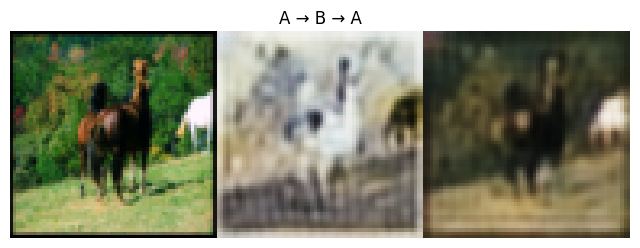

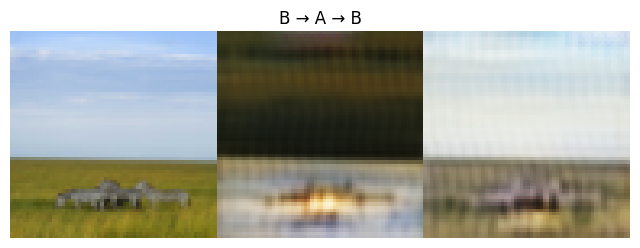

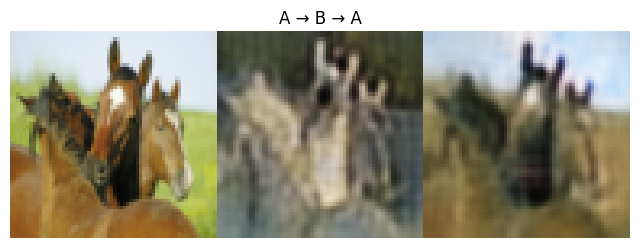

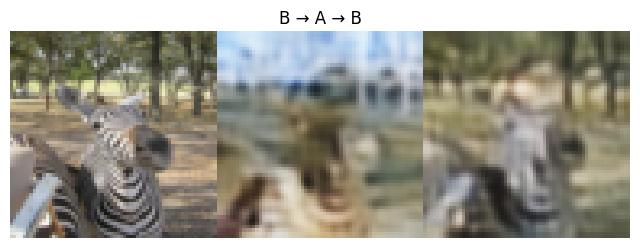

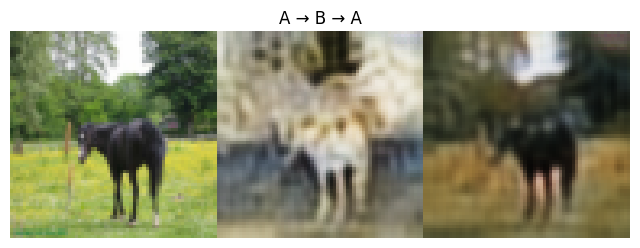

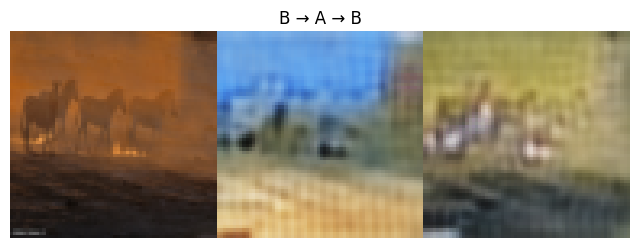

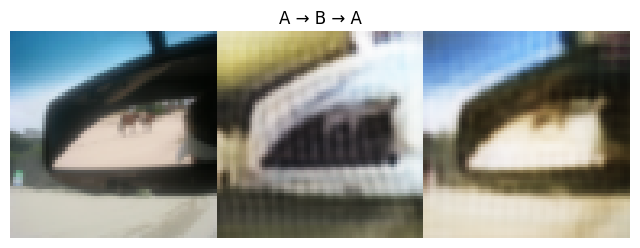

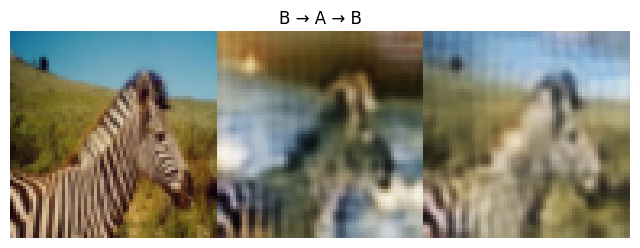

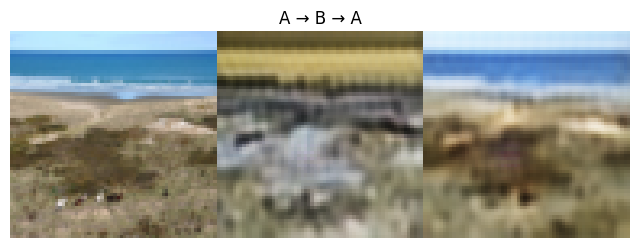

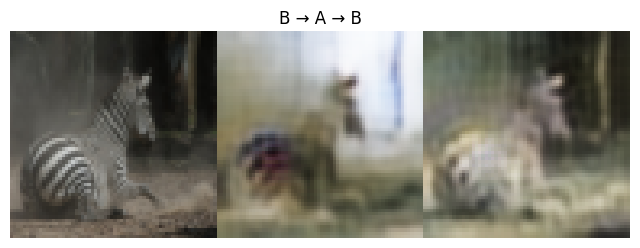

In [21]:
test_dataset = ImageDataset("data/horse2zebra/horse2zebra/testA",
                            "data/horse2zebra/horse2zebra/testB",
                            transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


evaluate_cycle_consistency(G_AB, G_BA, test_loader, device, cycle_loss_fn)

# Show triplets of transformations
visualize_cycle_triplets(G_AB, G_BA, test_loader, device, max_samples=5)

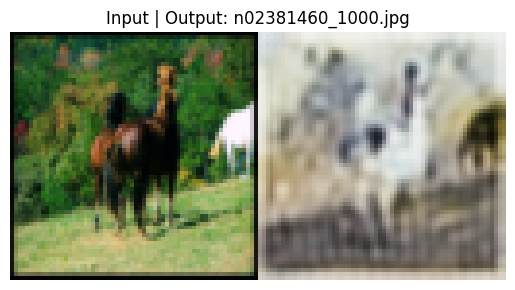

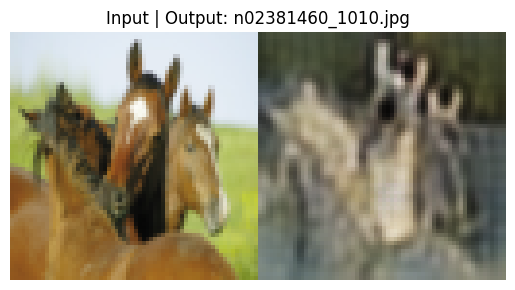

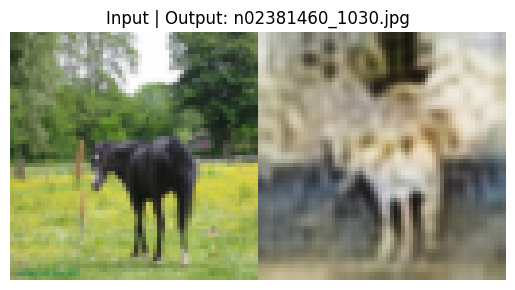

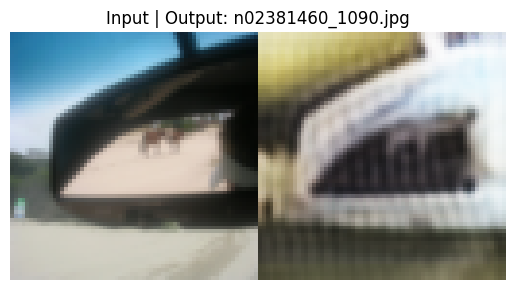

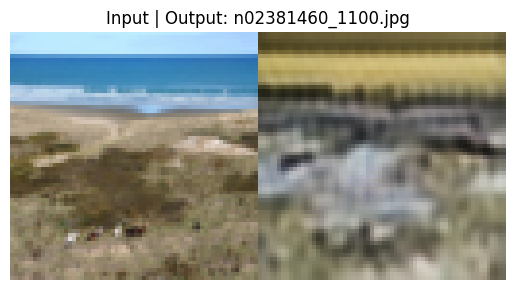

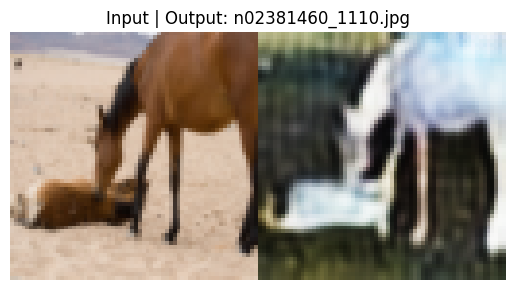

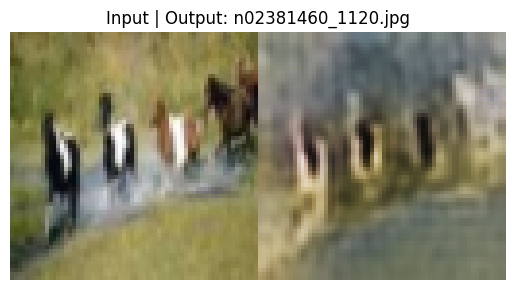

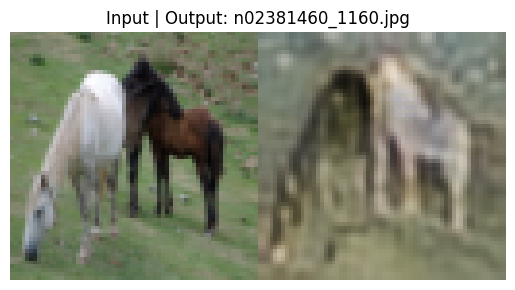

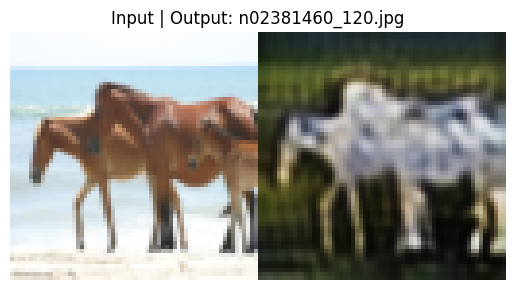

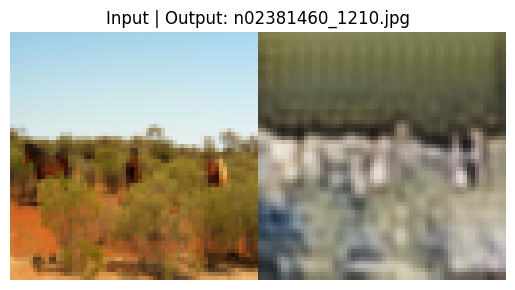

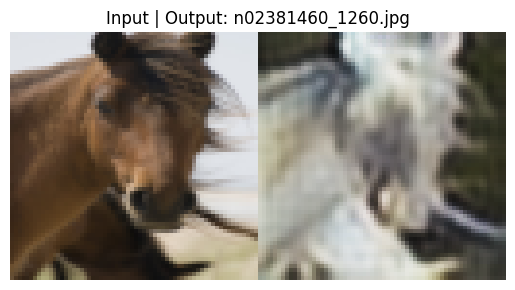

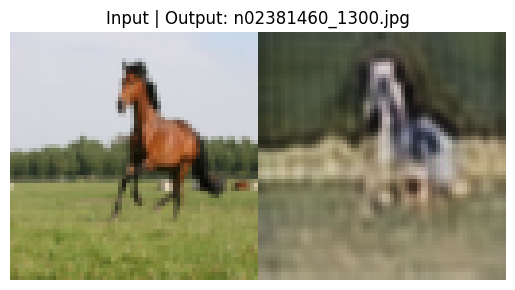

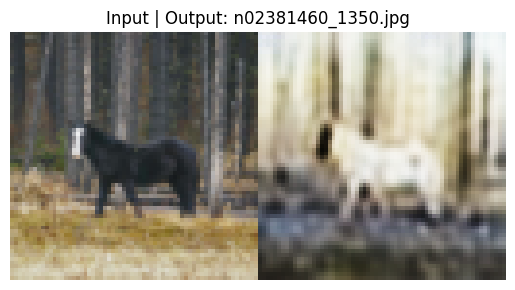

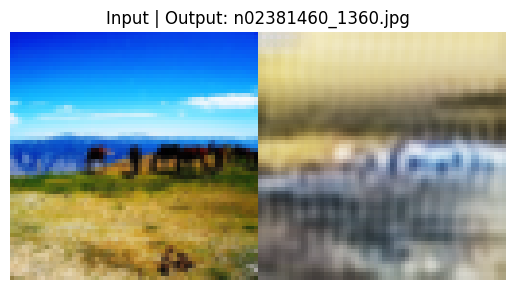

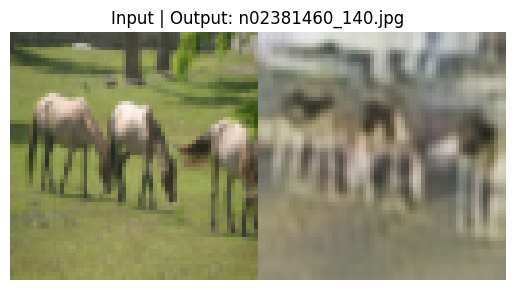

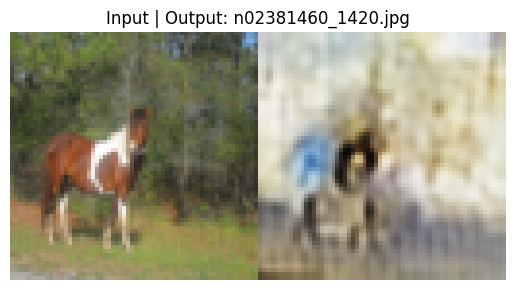

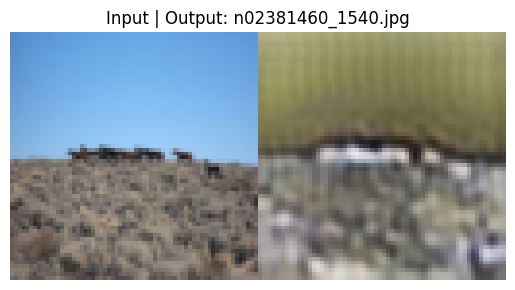

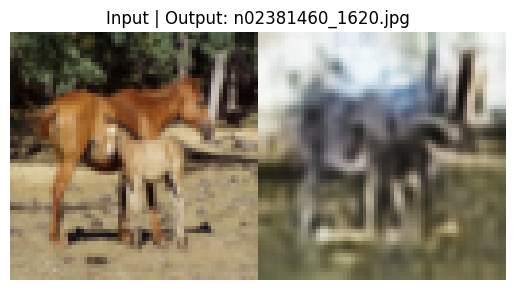

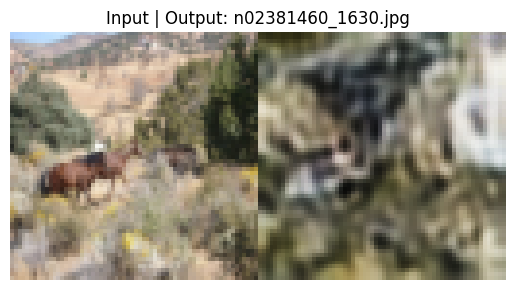

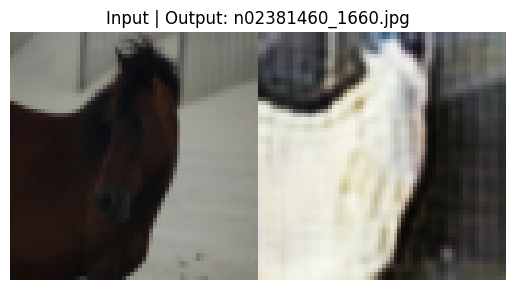

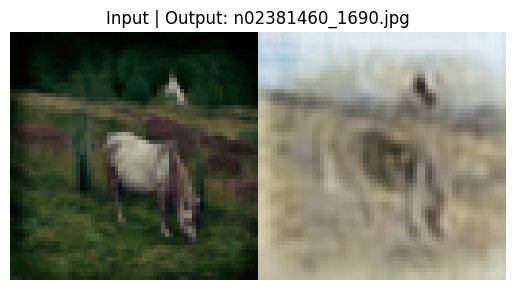

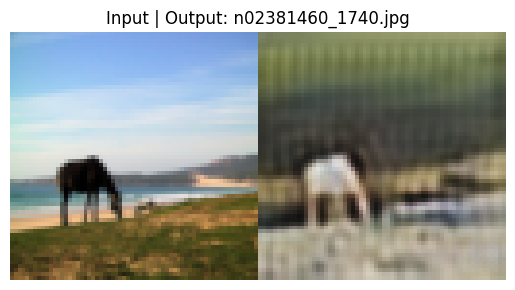

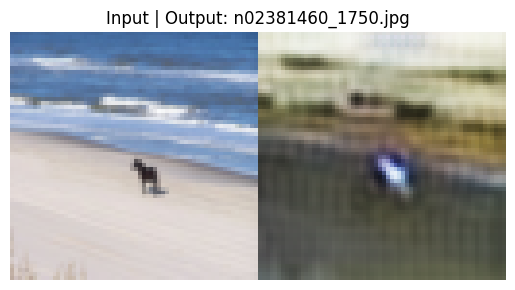

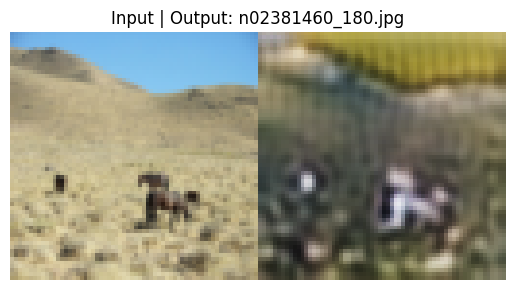

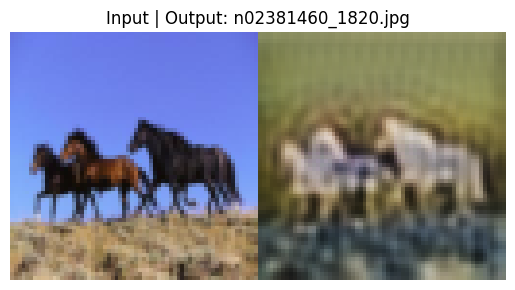

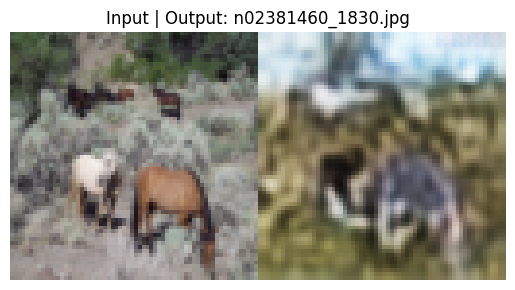

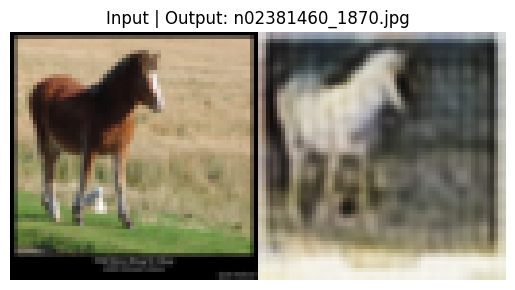

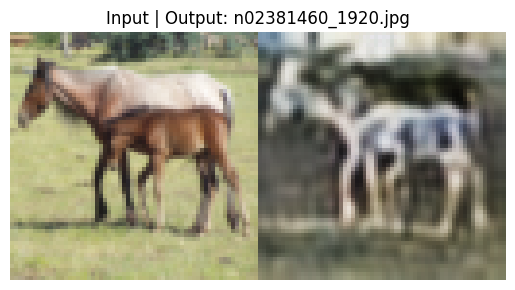

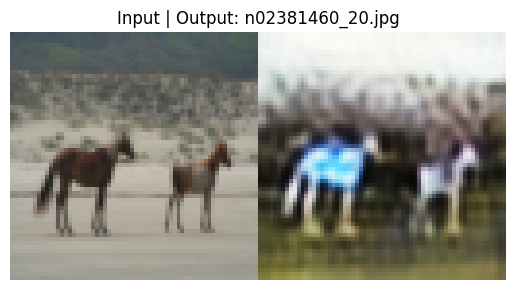

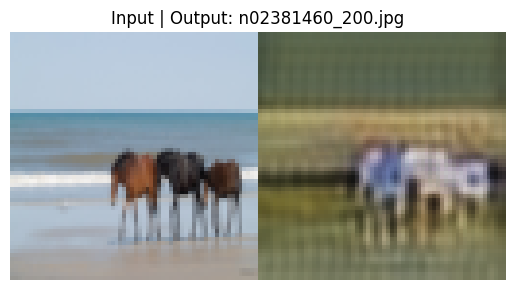

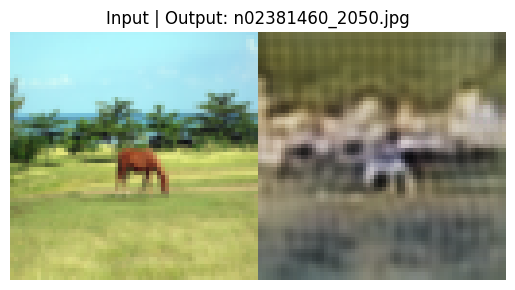

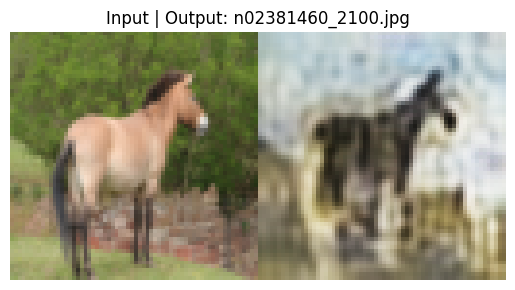

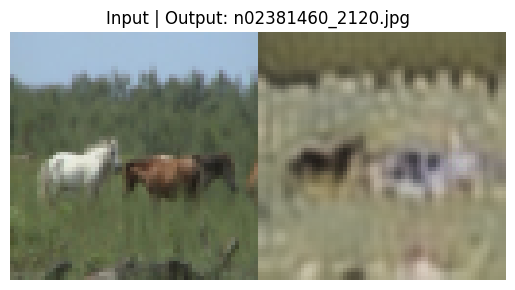

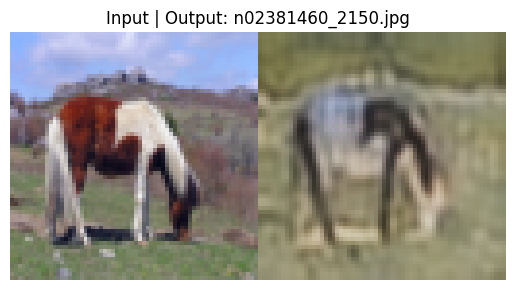

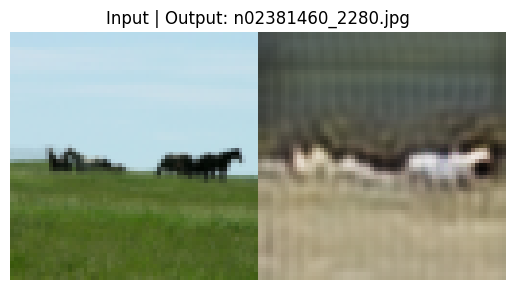

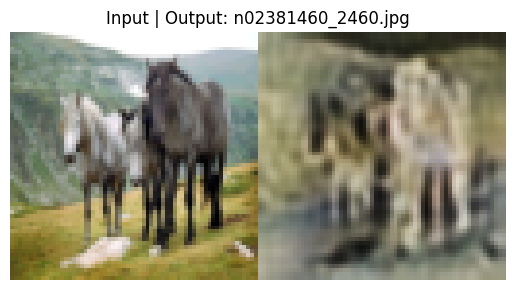

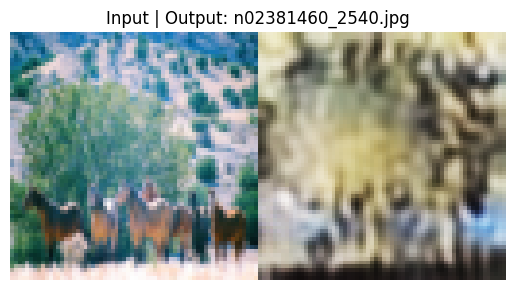

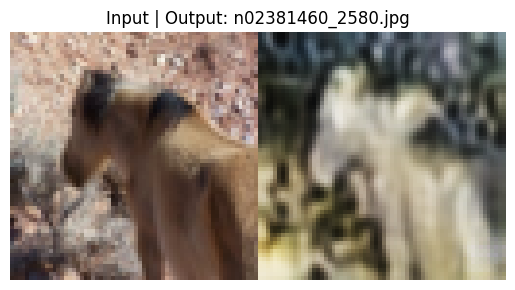

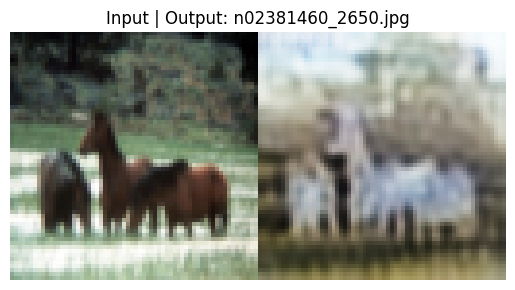

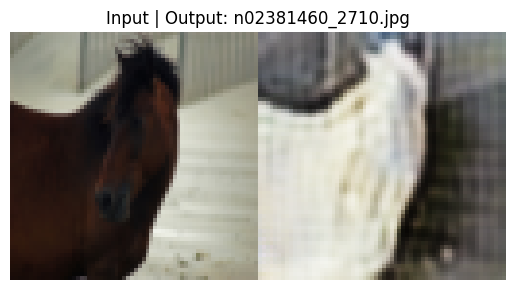

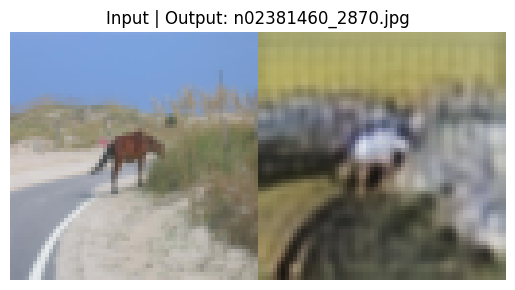

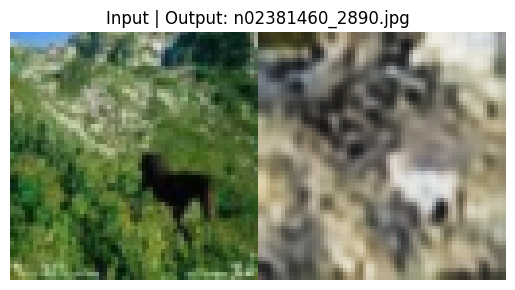

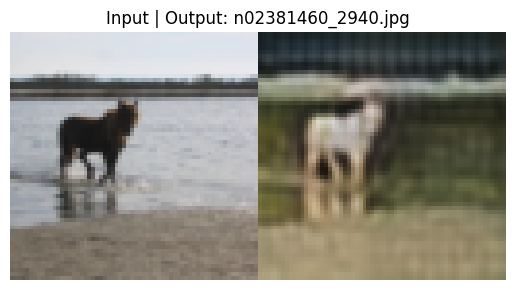

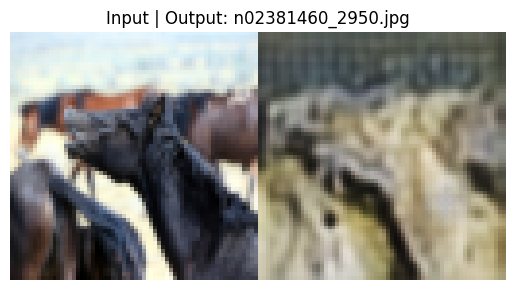

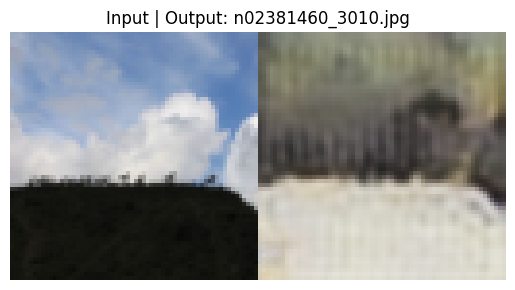

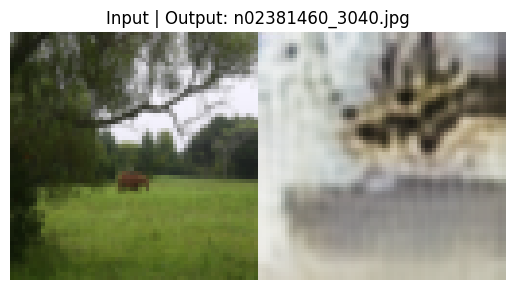

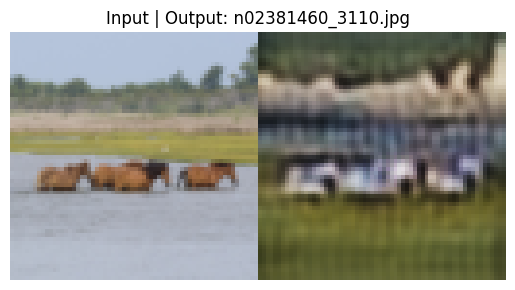

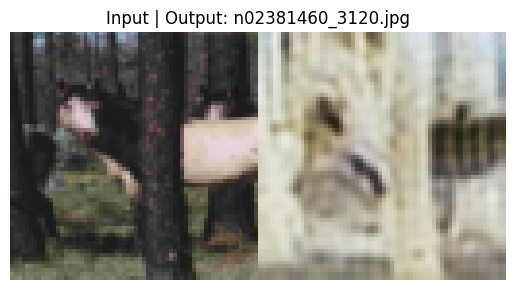

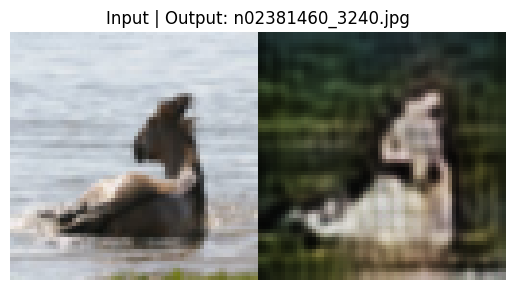

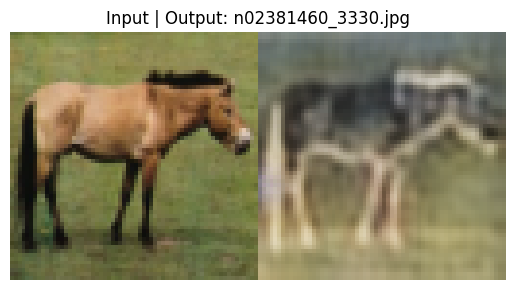

In [22]:
test_dir = "data/horse2zebra/horse2zebra/testA"
test_images = sorted(os.listdir(test_dir))[:50]

G_AB.eval()
with torch.no_grad():
    for i, fname in enumerate(test_images):
        img = Image.open(os.path.join(test_dir, fname)).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        fake = G_AB(img_tensor)
        result = torch.cat((img_tensor, fake), dim=3)
        result_img = (result.squeeze(0).cpu() + 1) / 2.0
        np_img = result_img.permute(1, 2, 0).numpy()
        plt.imshow(np_img)
        plt.title(f"Input | Output: {fname}")
        plt.axis('off')
        plt.show()
